In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from NoiseKD import Teacher

First hurdle. the embedding layer.  It requires the ints as inputs, not one hot.  i need one hot.  i will also need to rewire the LLM i use to do the same.  hmm.  save the weights, load it into a model that has the same shapes, but accepts one hot arrays, not vocab_indexes.

In [3]:
class TransformerEncoder(nn.Module):
    def __init__(self, embedding_dim, num_heads, hidden_dim, num_layers, dropout):
        super(TransformerEncoder, self).__init__()
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, num_heads, hidden_dim, dropout),
            num_layers
        )

    def forward(self, x):
        return self.transformer(x)

class SimpleLanguageModel(nn.Module):
    def __init__(self, vocab_size, sequence_length, embedding_dim, class_num, num_heads, hidden_dim, num_layers, dropout):
        super(SimpleLanguageModel, self).__init__()

        # Define the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Define the transformer encoder
        self.transformer_encoder = TransformerEncoder(embedding_dim, num_heads, hidden_dim, num_layers, dropout)
        
        self.fc1 = nn.Linear(sequence_length*embedding_dim, 1000)
        self.fc2 = nn.Linear(1000, 500)
        
        self.output_layer = nn.Linear(500, class_num)
        
        

    def forward(self, input_data):
        # Input_data is of shape (batch_size, sequence_length)
        # Apply embedding layer
        #print(input_data.shape)
        embedded = self.embedding(input_data)
        #print(embedded.shape)
        # Pass through the transformer encoder
        transformed = self.transformer_encoder(embedded)
        #print(transformed.shape) same as input duh: batch x sequence_length x embedding_dim
        flattened_tensor = transformed.view(-1,sequence_length*embedding_dim)
        f1 = nn.ReLU()(self.fc1(flattened_tensor))
        f2 = nn.ReLU()(self.fc2(f1))
        out = self.output_layer(f2)
        # Apply the output layer
        output = F.softmax(out,dim=1)

        return output
    
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

In [4]:
embedding_dim = 16
num_heads = 8
hidden_dim  = 11
num_layers = 2
dropout = 0.1
vocab_size = 80
class_num = vocab_size
batch_size = 23
sequence_length = 160

In [5]:
SLM = SimpleLanguageModel(vocab_size, sequence_length, embedding_dim, class_num, num_heads, hidden_dim, num_layers, dropout)

In [6]:
SLM

SimpleLanguageModel(
  (embedding): Embedding(80, 16)
  (transformer_encoder): TransformerEncoder(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
          )
          (linear1): Linear(in_features=16, out_features=11, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=11, out_features=16, bias=True)
          (norm1): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
       

In [79]:
input_data = torch.randint(low=0, high=vocab_size, size=(batch_size, sequence_length))
print(input_data.shape)
SLM(input_data).shape

torch.Size([23, 160])


torch.Size([23, 80])

In [8]:
count_parameters(SLM)

3105922

In [9]:
teacher_slm = Teacher(SLM,(sequence_length,)) #don't specify batch!!

In [72]:
##some of these configs made for more diverse outputs in teachers:
config_args = {"dist_type" : "ints" ##worked well
                      , "gen_m" : vocab_size
                      , "gen_n" : 1000
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.001
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_high_epochs = {"dist_type" : "ints" ##okay, but not as well as config_args.
                      , "gen_m" : vocab_size
                      , "gen_n" : 1000
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.001
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_higher_lr = {"dist_type" : "ints" ##lower was worse.  raise it. 0.003 looks great.  this is the best.
                      , "gen_m" : vocab_size
                      , "gen_n" : 2000
                      , "gen_epochs" : 50
                      , "gen_lr" :  0.003 ##0.003
                      , "random_shuffle" : 0.8
                      , "out_type" : "one-hot" }

config_args_less_data = {"dist_type" : "ints" ##worse
                      , "gen_m" : vocab_size
                      , "gen_n" : 500
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.003
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_high_shuffle = {"dist_type" : "ints" ##one bar..
                      , "gen_m" : vocab_size
                      , "gen_n" : 10_000
                      , "gen_epochs" : 10
                      , "gen_lr" : 0.05
                      , "random_shuffle" : 0.9
                      , "out_type" : "one-hot" }

config_args_small_batch = {"dist_type" : "ints" ##this one was the first to do well.  not just one bar and the rest nearly zero.
                      , "gen_m" : vocab_size
                      , "gen_n" : 10_000
                      , "gen_epochs" : 10
                      , "gen_lr" : 0.05
                      , "random_shuffle" : 0.5
                      , "batch_size" : 10
                      , "out_type" : "one-hot" }

In [73]:
teacher_slm.configure(**config_args_higher_lr) #this is dying.  might be time for colab!!

Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)
lets try ints!



Configuring Teacher:: 100%|█████████████████████| 50/50 [01:37<00:00,  1.96s/it]

Teacher Configured


In [74]:

args = { 'val_train' : "train"
                      , 'n' : 100_000
                      , 'dist_type' : 'ints'
                      , 'm' : vocab_size
                      , 'std': 1.0
        }
teacher_slm.generate_data(**args)


Configuring Teacher::  21%|███▊              | 428/2000 [00:10<00:40, 38.74it/s]


Configuring Teacher::  44%|███████▊          | 870/2000 [00:22<00:29, 38.96it/s]


Configuring Teacher::  67%|███████████▍     | 1345/2000 [00:33<00:15, 43.59it/s]


Configuring Teacher::  92%|███████████████▌ | 1830/2000 [00:44<00:03, 42.85it/s]


Configuring Teacher:: 100%|█████████████████| 2000/2000 [00:48<00:00, 40.87it/s]


In [13]:
teacher_slm.model.embedding.weight.detach().numpy() #use this to make the matrix, just linear? not sure.

array([[ 1.2507943 ,  0.916587  ,  0.32384518, ..., -0.09755162,
         0.8008551 ,  0.10803049],
       [ 0.05464775, -1.8672564 , -0.4680833 , ..., -0.8847053 ,
        -1.0480814 ,  0.21051157],
       [-0.30357024,  0.9832738 ,  0.3966559 , ...,  0.60099226,
         0.8774878 , -1.7313257 ],
       ...,
       [-0.7661908 , -0.7953235 , -0.93700886, ...,  0.971414  ,
         0.67714196, -0.2938975 ],
       [ 0.00356212, -0.49576432,  0.28711528, ..., -1.3693084 ,
         0.4073821 , -0.84306633],
       [-1.4479548 ,  0.6393707 , -0.54342085, ...,  1.0211395 ,
         1.0912967 ,  0.20077224]], dtype=float32)

In [76]:
test = torch.argmax(teacher_slm.train_targets,axis = -1) #the code is right, i just need this to be a better dist.

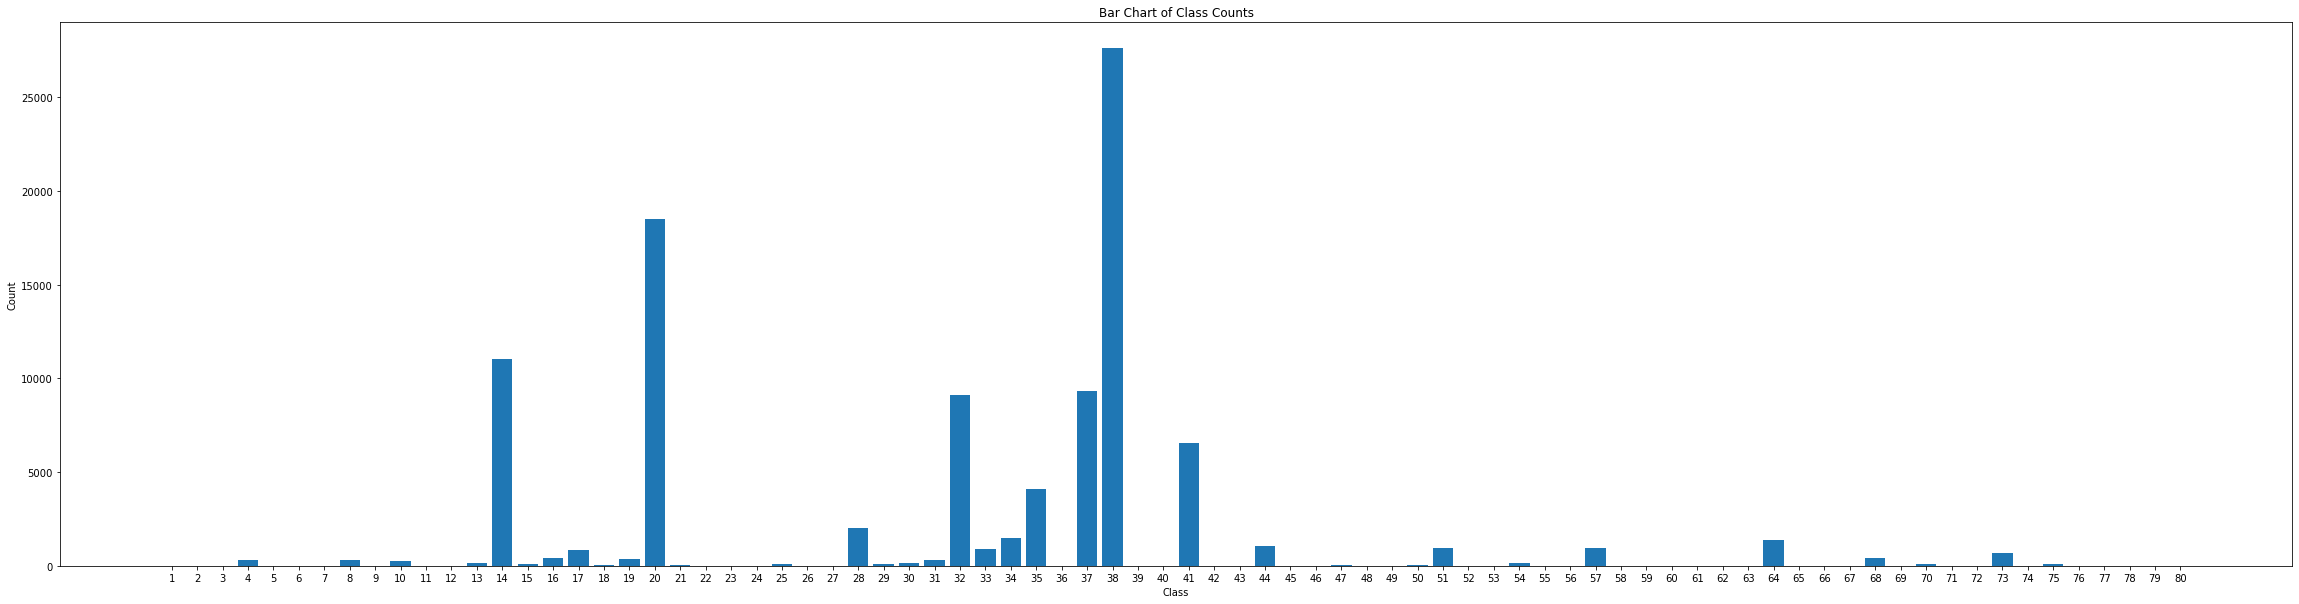

In [77]:
import numpy as np
import matplotlib.pyplot as plt
class_counts = [np.count_nonzero(test == i) for i in range(1, class_num + 1)]

# Create a bar chart
plt.figure(figsize=(40, 10))
plt.bar(range(1, class_num + 1), class_counts, align='center')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Bar Chart of Class Counts')
plt.xticks(range(1, class_num + 1))

plt.show()

specify gen outputs.  we need one hots
i can do this better than chat gpt lol

In [16]:
##this function works, it is in LABNET.  
def one_hot_last_dim(tensor_shape):
    num_classes = tensor_shape[-1]
    random_idx = np.random.randint(1, num_classes + 1, size=tensor_shape[:-1])
    zero_tensor = np.zeros(tensor_shape, dtype=int)
    last_dim_indices = np.arange(num_classes)
    zero_tensor[..., :, last_dim_indices] = (random_idx[..., np.newaxis] == last_dim_indices)
    return zero_tensor

In [ ]:
axis_to_shuffle = 0

# Shuffle the tensor along the specified axis
shuffled_tensor = np.take(x, np.random.permutation(x.shape[0]), axis=0)

print(shuffled_tensor)


In [ ]:
import random


for i in range(10):
    random_number = random.random()
    print(random_number)

In [ ]:
#next is to extract the parts.  we need to take out the embedding layer, make it linear, and then take out the layer before softmax.  